In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 45 kB/s 
     |████████████████████████████████| 199 kB 47.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=b204adf9ec36503ddcd693680984fc323ee105252342d28fb28e183d5d1a6fdf
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, col, max, countDistinct

# Задание 1

В этом задании, используя датасет "Топ-50 самых продаваемых книг на Amazon в период с 2009 по 2019 годы", требуется выполнить следующее:

1. Создать спарк сессию.

2. Прочитать датасет в датафрейм.

3. Используя только RDD вычислить среднюю цену всех книг, у которых рейтинг выше 4.7

4. Построить гистограмму распределения рецензий (столбец Reviews).

5. Построить матрицу корреляции для столбцов "User Rating", "Reviews" и "Price".

6. Используя библиотеку seaborn построить парные графики (pairplots) столбцов "User Rating", "Reviews" и "Price".

In [3]:
spark_session = SparkSession.builder.getOrCreate()

In [8]:
data = spark_session.read.csv('bestsellers with categories.csv', inferSchema=True, header=True)
data.show()

+--------------------+--------------------+-----------+-------+-----+----+-----------+
|                Name|              Author|User Rating|Reviews|Price|Year|      Genre|
+--------------------+--------------------+-----------+-------+-----+----+-----------+
|10-Day Green Smoo...|            JJ Smith|        4.7|  17350|    8|2016|Non Fiction|
|   11/22/63: A Novel|        Stephen King|        4.6|   2052|   22|2011|    Fiction|
|12 Rules for Life...|  Jordan B. Peterson|        4.7|  18979|   15|2018|Non Fiction|
|1984 (Signet Clas...|       George Orwell|        4.7|  21424|    6|2017|    Fiction|
|5,000 Awesome Fac...|National Geograph...|        4.8|   7665|   12|2019|Non Fiction|
|A Dance with Drag...| George R. R. Martin|        4.4|  12643|   11|2011|    Fiction|
|A Game of Thrones...| George R. R. Martin|        4.7|  19735|   30|2014|    Fiction|
|A Gentleman in Mo...|         Amor Towles|        4.7|  19699|   15|2017|    Fiction|
|A Higher Loyalty:...|         James Comey|

In [9]:
data.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- User Rating: double (nullable = true)
 |-- Reviews: integer (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Genre: string (nullable = true)



In [15]:
data.filter(col("User Rating") >= 4.7).agg({"Price": "avg"}).show()

+------------------+
|        avg(Price)|
+------------------+
|11.560975609756097|
+------------------+



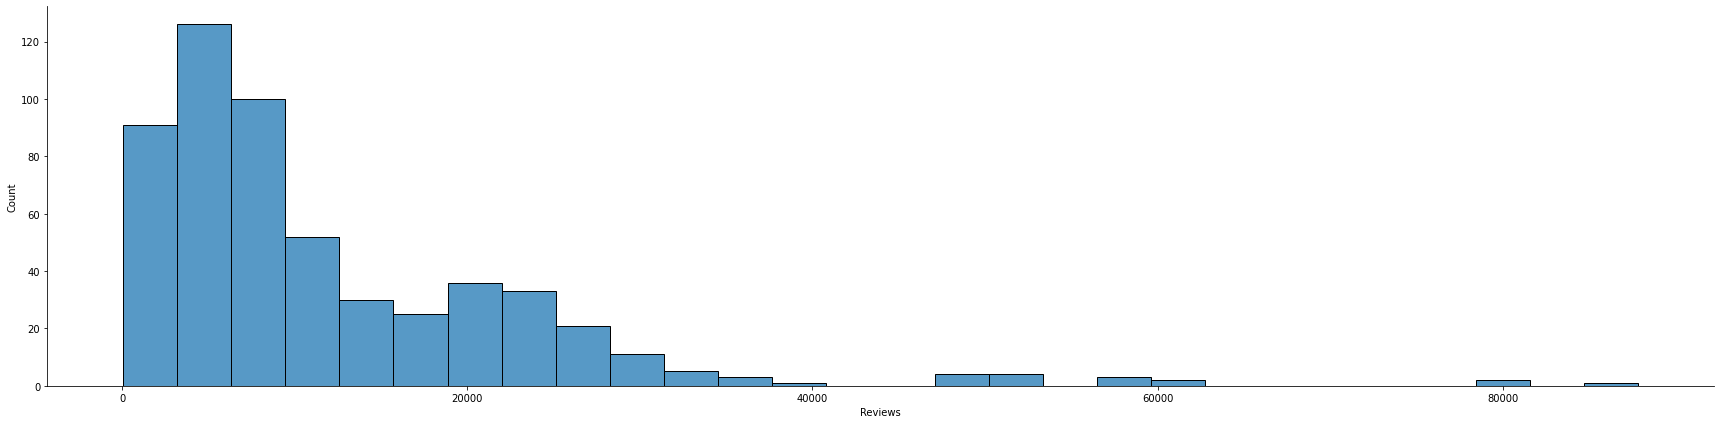

In [16]:
data_pd = data.toPandas()
sns.displot(x= 'Reviews', data=data_pd, height=6, aspect=4/1)
plt.show()

In [21]:
data.corr("User Rating", "Price")

-0.13308628728088093

In [22]:
data.corr("Reviews", "Price")

-0.10918188342780513

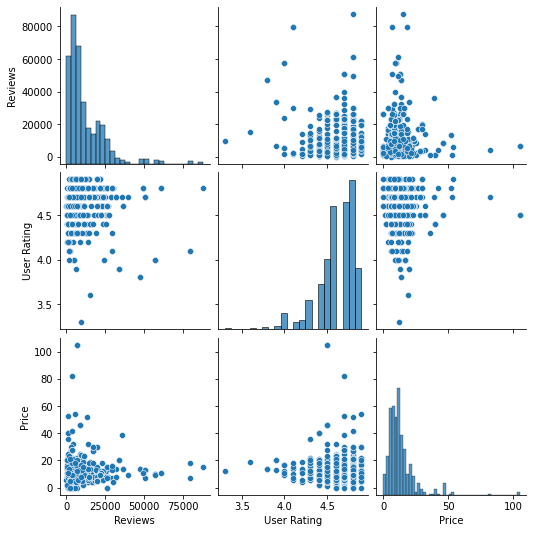

In [24]:
data_pd_cut = data_pd[['Reviews', 'User Rating', 'Price']]
sns.pairplot(kind="scatter", data=data_pd_cut)

# Задание 2

При выполнении этого задания разрешается использовать только Spark SQL. Для датасета из предыдущего задания выполните следующее:

1. Найдите автора с самым высоким рейтингом.
2. Найдите трех авторов с самым низким рейтингом.
3. Определите какой автор получил наибольшее количество рецензий.
4. Определите какой автор написал наибольшее количество книг за весь доступный в данных период.
5. Определите какая книга жанра "Fiction" имеет самый маленький рейтинг.
6. Определите какая книга жанра "Non Fiction" имеет самый высокий рейтинг.

In [59]:
author = data.sort(data['User Rating'].desc())
author.select('Author', 'User Rating').limit(1).show()

+---------------+-----------+
|         Author|User Rating|
+---------------+-----------+
|Bill Martin Jr.|        4.9|
+---------------+-----------+



In [45]:
authors_data = data.sort(data['User Rating'].asc())
authors_data.select('Author', 'User Rating').limit(3).show()

+------------+-----------+
|      Author|User Rating|
+------------+-----------+
|J.K. Rowling|        3.3|
|  Harper Lee|        3.6|
|   E L James|        3.8|
+------------+-----------+



In [52]:
author_reviews = data.sort(data['Reviews'].desc())
author_reviews.select('Author', 'Reviews').limit(1).show()

+-----------+-------+
|     Author|Reviews|
+-----------+-------+
|Delia Owens|  87841|
+-----------+-------+



In [50]:
author_reviews = data.sort(data['Reviews'].desc()).collect()[0]["Author"]
author_reviews

'Delia Owens'

In [53]:
books = data.groupBy("Author").count().sort("count", ascending=False)
books.select('Author', 'count').limit(1).show()

+-----------+-----+
|     Author|count|
+-----------+-----+
|Jeff Kinney|   12|
+-----------+-----+



In [55]:
fiction_min = data.filter(data["genre"] == 'Fiction').sort("User Rating", ascending=True)
fiction_min.select('Name', 'User Rating', 'Genre').limit(1).show()

+------------------+-----------+-------+
|              Name|User Rating|  Genre|
+------------------+-----------+-------+
|The Casual Vacancy|        3.3|Fiction|
+------------------+-----------+-------+



In [58]:
nfiction_max = data.filter(data["genre"] == 'Non Fiction').sort("User Rating", ascending=False)
nfiction_max.select('Name', 'User Rating', 'Genre').limit(1).show()

+--------------------+-----------+-----------+
|                Name|User Rating|      Genre|
+--------------------+-----------+-----------+
|Hamilton: The Rev...|        4.9|Non Fiction|
+--------------------+-----------+-----------+



# Задание 3

Постройте гистограмму среднего количества рецензий по годам. В виде отдельной гистограммы визуализируйте количество книг жанра "Fiction" и "Non Fiction" за весь доступный период.

In [75]:
hist_cut = data.groupBy("Year").avg("Reviews").sort("Year", ascending=True)
hist_cut.show()

+----+------------+
|Year|avg(Reviews)|
+----+------------+
|2009|     4710.12|
|2010|     5479.62|
|2011|     8100.82|
|2012|    13090.92|
|2013|    13098.14|
|2014|    15859.94|
|2015|    14233.38|
|2016|     14196.0|
|2017|     12888.4|
|2018|    13930.42|
|2019|    15898.34|
+----+------------+



In [76]:
hist_cut_pd = hist_cut.toPandas()
hist_cut_pd.head()

,Year,avg(Reviews)
0,2009,4710.12
1,2010,5479.62
2,2011,8100.82
3,2012,13090.92
4,2013,13098.14


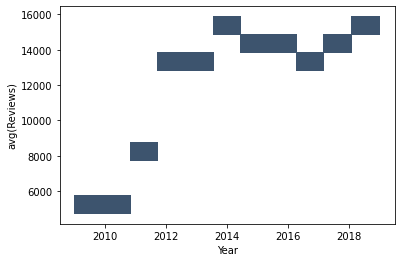

In [77]:
sns.histplot(data = hist_cut_pd, x = 'Year', y = 'avg(Reviews)', bins = len(hist_cut_pd))

In [78]:
fiction = data.filter(data["Genre"] == 'Fiction').count()
nfiction = data.filter(data["Genre"] == 'Non Fiction').count()

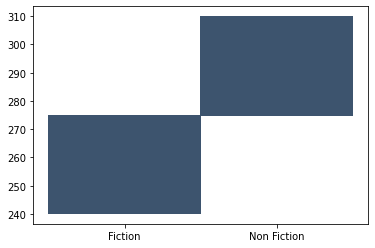

In [79]:
sns.histplot(x=("Fiction", "Non Fiction"), y=(fiction, nfiction))
plt.show()